In [1]:
# Não exibir warnings
import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr
sys.stderr = sys.__stderr__  # unsilence stderr

In [2]:
#https://github.com/PacktPublishing/Neural-Network-Projects-with-Python/blob/master/Chapter04/main_vgg16.py

from keras.applications.vgg19 import VGG19
from keras.models import Model

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#Função de geração da matriz de confusão
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig  

In [4]:
batch = 32
#num_train = 5600
#num_validation = 2400

In [5]:
### Transfer Learning ###

vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(128,128,3))

# Freeze the pre-trained layers
for layer in vgg19.layers:
    layer.trainable = False

# Add a fully connected layer with 2 nodes at the end 
input_ = vgg19.input
output_ = vgg19(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(2, activation='sigmoid')(last_layer)
model = Model(input=input_, output=last_layer)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [6]:
print ("### Estrutura VGG19 ###")
vgg19.summary()

print ("\n\n### Estrutura do modelo ###")
model.summary()

### Estrutura VGG19 ###
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 3

In [7]:
# Part 2 - Fitting the CNN to the images

from keras.preprocessing.image import ImageDataGenerator

#Conjunto de treinamento
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('classificador_A/train',
                                                 target_size = (128, 128),
                                                 color_mode="rgb",
                                                 batch_size = batch,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

print (training_set.class_indices)
#Conjunto de validação
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory('classificador_A/validation/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = batch, #alterado para 1
                                            class_mode = 'categorical',
                                            shuffle=True)
num_train = training_set.samples
num_validation = validation_set.samples

Found 4996 images belonging to 2 classes.
{'documentos': 0, 'nao_documentos': 1}
Found 2396 images belonging to 2 classes.


In [8]:
with tf.device('/gpu:0'): #rodar na GPU
    history = model.fit_generator(training_set,
                         steps_per_epoch = (num_train//batch),
                         epochs = 50,
                         validation_data = validation_set,
                         validation_steps = (num_validation//batch), verbose=1)
    

model.save('modelo_classificador_A_VGG19_dist_01.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
156/156 [==============================] - 155s 991ms/step - loss: 0.1424 - accuracy: 0.9506 - val_loss: 0.0414 - val_accuracy: 0.9704
Epoch 2/50
156/156 [==============================] - 105s 671ms/step - loss: 0.0854 - accuracy: 0.9722 - val_loss: 0.0628 - val_accuracy: 0.9683
Epoch 3/50
156/156 [==============================] - 100s 639ms/step - loss: 0.0688 - accuracy: 0.9769 - val_loss: 0.1339 - val_accuracy: 0.9788
Epoch 4/50
156/156 [==============================] - 103s 662ms/step - loss: 0.0575 - accuracy: 0.9788 - val_loss: 0.0451 - val_accuracy: 0.9835
Epoch 5/50
156/156 [==============================] - 100s 640ms/step - loss: 0.0469 - accuracy: 0.9839 - val_loss: 0.0070 - val_accuracy: 0.9827
Epoch 6/50
156/156 [==============================] - 99s 632ms/step - loss: 0.0480 - accuracy: 0.9833 - val_loss: 0.0114 - val_accuracy: 0.9822
Epoch 7/50
156/156 [==========

Train accuracy: 0.996
Train loss: 0.011 

Validation accuracy: 0.983
Validation loss: 0.059


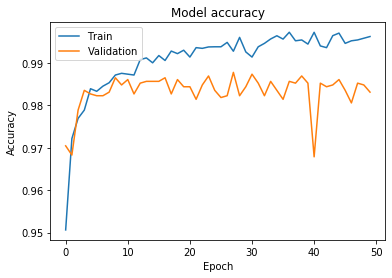

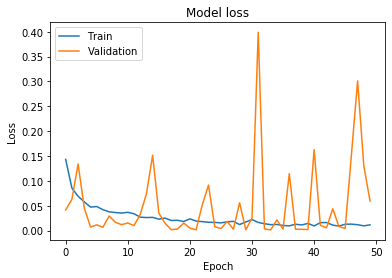

In [10]:
# Final accuracy and loss
print ("Train accuracy: %.3f" % (history.history['accuracy'][-1]))
print ("Train loss: %.3f" % (history.history['loss'][-1]),"\n")

print ("Validation accuracy: %.3f" % (history.history['val_accuracy'][-1]))
print ("Validation loss: %.3f" % (history.history['val_loss'][-1]))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Matriz de confusão para o conjunto de validação ###
Found 2396 images belonging to 2 classes.
74/74 [==============================] - 26s 354ms/step


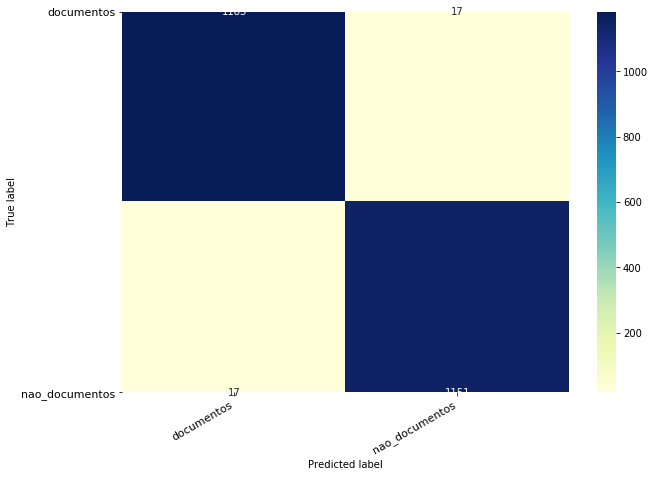

In [11]:
### Conjunto de Validação ###

print ("### Matriz de confusão para o conjunto de validação ###")

#Conjunto de validação
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory('classificador_A/validation/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = batch, #alterado para 1
                                            class_mode = 'categorical',
                                            shuffle= False)


#Confution Matrix
Y_pred = model.predict_generator(validation_set, num_validation//batch, verbose=1)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = validation_set.classes
cm =confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["documentos", "nao_documentos"], figsize = (10,7), fontsize=11)


### Matriz de confusão para o conjunto de teste ###
Found 1198 images belonging to 2 classes.
1198/1198 [==============================] - 23s 19ms/step
Test accuracy: 0.976
Test loss: 0.000


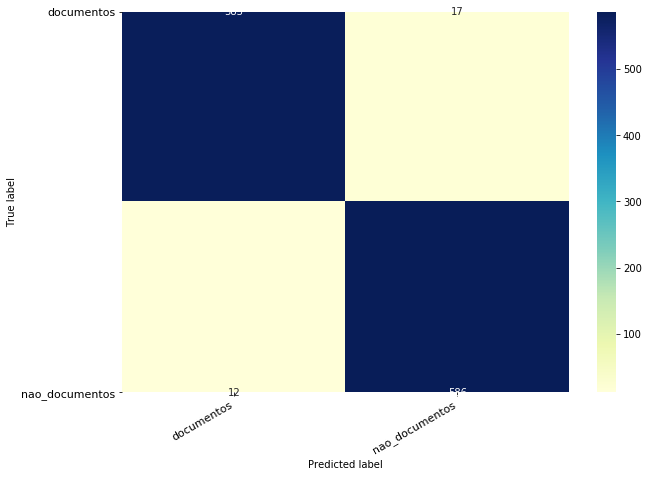

In [12]:
### Conjunto de Teste ###

print ("### Matriz de confusão para o conjunto de teste ###")

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('classificador_A/test/',
                                            target_size = (128, 128),
                                            color_mode="rgb",
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle=False)
num_test = test_set.samples


#Confution Matrix
Y_pred = model.predict_generator(test_set, num_test, verbose=1)

test_preds = np.argmax(Y_pred, axis=-1)
l=test_preds.shape[0]
test_trues = test_set.classes
cm =confusion_matrix(test_trues[:l], test_preds)

print_confusion_matrix(cm, ["documentos", "nao_documentos"], figsize = (10,7), fontsize=11)

# Accuracy and Loss for the Test set
loss, acc = model.evaluate_generator(test_set, num_test, verbose=1)

# Final accuracy and loss
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)
